# Inverter Based Amplifier Parameters Calculation

## Architecture:
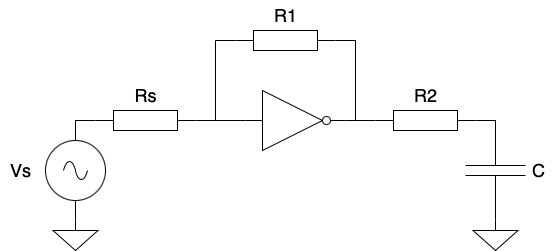

### Using the driving point signal flow graph of this circuit, we find the transfer function easily. For more information about this technique, see: Schmid, Hanspeter, et Alex Huber. « Analysis of Switched-Capacitor Circuits Using Driving-Point Signal-Flow Graphs ». Analog Integrated Circuits and Signal Processing 96, nᵒ 3 (septembre 2018): 495‑507. https://doi.org/10.1007/s10470-018-1131-7.


## Transfer function and signal flow graph

### Driving Point Signal Flow Graph:

![Capture d’écran 2024-04-08 à 12.21.35.png](<attachment:Capture d’écran 2024-04-08 à 12.21.35.png>)
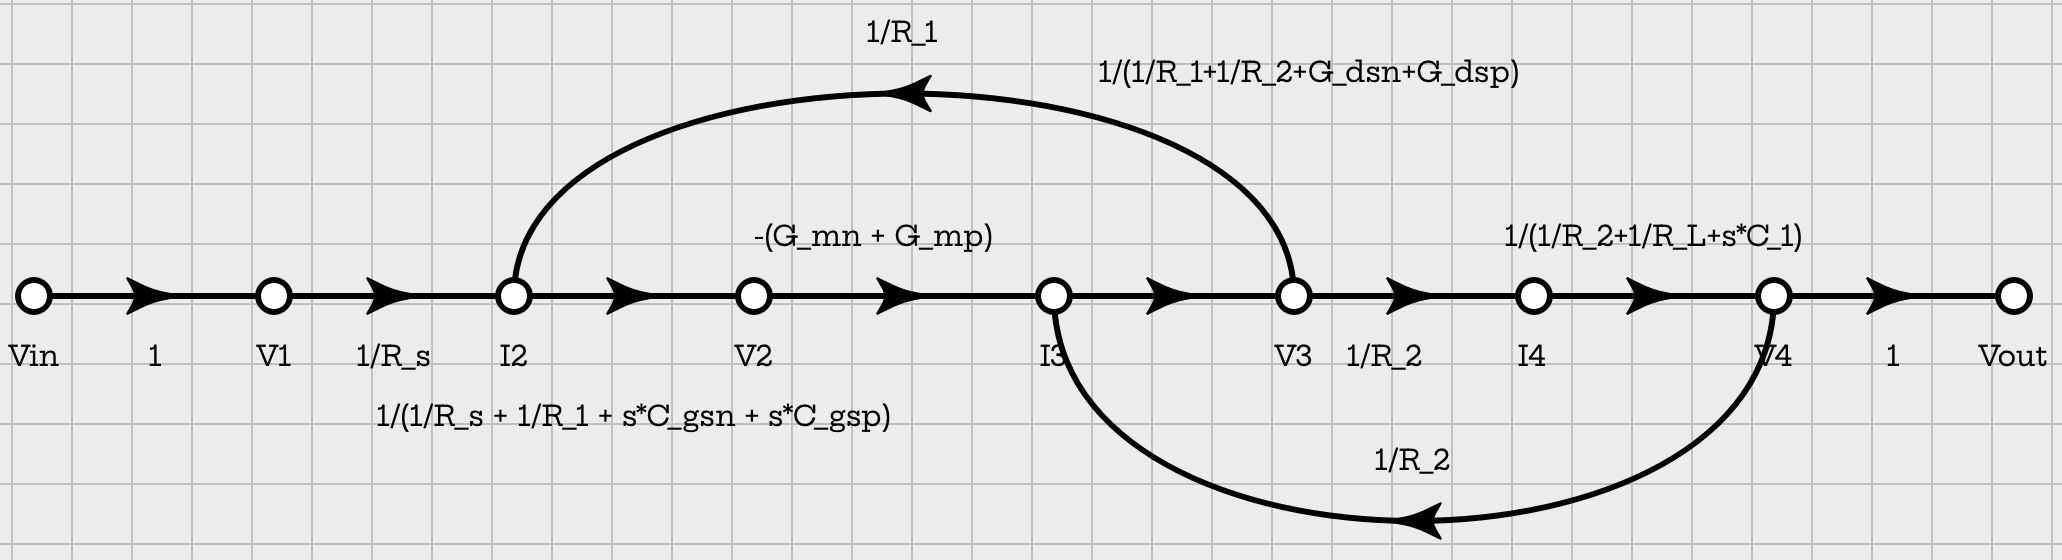

### Transfer function from DPSFG

In [1]:
import sympy as sp
import numpy as np

Delta = sp.symbols('Delta')
L1,L2 = sp.symbols('L1,L2')
T_num = sp.symbols('T_num')
T_den = sp.symbols('T_den')
T_io = sp.symbols('T_io')

R_s,G_dsp,C_1,G_mn,R_L,C_gsp,C_gsn,G_dsn,s,G_mp,R_2,R_1 = sp.symbols('R_s,G_dsp,C_1,G_mn,R_L,C_gsp,C_gsn,G_dsn,s,G_mp,R_2,R_1')


In [2]:
loops = [(L1, (-G_mn - G_mp)/(R_1*(G_dsn + G_dsp + 1/R_2 + 1/R_1)*(C_gsn*s + C_gsp*s + 1/R_s + 1/R_1))), (L2, 1/(R_2**2*(C_1*s + 1/R_L + 1/R_2)*(G_dsn + G_dsp + 1/R_2 + 1/R_1)))]
determinant = [(Delta, -L1 - L2 + 1)]
denominator = [(T_den, Delta)]

In [3]:
P1,D1 = sp.symbols('P1,D1')
paths = [(P1, (-G_mn - G_mp)/(R_2*R_s*(C_1*s + 1/R_L + 1/R_2)*(G_dsn + G_dsp + 1/R_2 + 1/R_1)*(C_gsn*s + C_gsp*s + 1/R_s + 1/R_1))), (D1, 1)]
numerator = [(T_num, D1*P1)]

In [4]:
transfer_function = [(T_io, T_num/T_den)]
T=T_io.subs(transfer_function).subs(numerator).subs(denominator).subs(determinant).subs(paths).subs(loops).simplify()

# In our case we consider Rs close to 0 and Rl close to infinit 
T = T.subs(R_s,0).simplify()
T = T.limit(R_L, sp.oo).simplify()

print("The transfer function is: ")
display(T)

gain_formula = T.subs(s,0)
print("The gain is: ")
display(gain_formula)

The transfer function is: 


-R_1*(G_mn + G_mp)/(C_1*G_dsn*R_1*R_2*s + C_1*G_dsp*R_1*R_2*s + C_1*R_1*s + C_1*R_2*s + G_dsn*R_1 + G_dsp*R_1 + 1)

The gain is: 


-R_1*(G_mn + G_mp)/(G_dsn*R_1 + G_dsp*R_1 + 1)

# Simulation Parameters

In [5]:
# Conditions to store simulation if usefull 
store_sim = False

# Arrays to store the results of the simulations
op = np.zeros(7)    # order: G_mn, G_mp, G_dsn, G_dsp, C_gsn, C_gsp, Vdc
param_values = np.zeros(8)    # order: Vdd, Wn, Ln, Wp, Lp, R_1, R_2, C_1
results_calc = np.zeros(4)    # order: gain (in dB), cut-off, noise, power
results_sim = np.zeros(4)    # order: gain (in dB), cut-off, noise, power

In [6]:
# order: Vdd, Wn, Ln, Wp, Lp, R_1, R_2, C_1
param_values = np.array([1.25, 40, 0.15, 80, 0.15, 1e5, 1e5, 2.768e-12])  

#The values are stored in the following order: G_mn, G_mp, G_dsn, G_dsp, C_gsn, C_gsp, Vdc
op =[516.8e-06,376.7e-06,28e-06,48.71e-06,12.32e-15,33.58e-15, 0.5901]  

## Gain computation

In [7]:
gain = gain_formula.subs([(G_mn, op[0]), (G_mp, op[1]), (G_dsn, op[2]), 
                          (G_dsp, op[3]), (C_gsn, op[4]), (C_gsp, op[5])])

In [8]:
# Minimal value of R1 to have a gain of 20dB (10)
R1_perf = sp.solve(gain + 10, R_1)
R1_perf = R1_perf[0].evalf()
print("The minimal value of R1 to have a gain of 20dB is: ", R1_perf)


The minimal value of R1 to have a gain of 20dB is:  79113.9240506329


In [9]:
# Evaluate the numerical value of the gain
numerical_gain = gain.subs(R_1, param_values[5]).evalf()
print("The numerical value of the gain is: ", numerical_gain)

The numerical value of the gain is:  -10.3044631530389


In [10]:
import math

# gain in dB
gain_db = 20 * math.log10(abs(numerical_gain))
print("The gain in dB is: ", gain_db)

The gain in dB is:  20.260507412365545


In [11]:
results_calc[0] = gain_db

## Cut-Off frequency computation

In [12]:
T_den = sp.denom(T).simplify()
cutoff_frequency = 500e3

# Update the expression with values in op and R1
T_den = T_den.subs([(G_mn, op[0]), (G_mp, op[1]), (G_dsn, op[2]), 
                    (G_dsp, op[3]), (C_gsn, op[4]), (C_gsp, op[5]),
                    (R_1, param_values[5])])
T_den_sim = T_den
# Update the expression with the new value of s (2*pi*f)
T_den = T_den.subs(s, 2*sp.pi*cutoff_frequency) 

In [13]:
#choosing a value for C1 by solving the denominator
R2 = param_values[6]
T_den = T_den.subs(R_2, R2)
C1_perf = sp.solve(T_den, C_1)
print("The value of C1 to have a cut-off frequency of 500kHz is ", C1_perf[0].evalf())

The value of C1 to have a cut-off frequency of 500kHz is  -2.85396031754694e-12


In [14]:
# As we don't have exactly same values for components,
# let's find the cutoff frequency for the values we have
T_den_sim = T_den_sim.subs([(C_1, param_values[7]), (R_2, param_values[6])])
cutoff_frequency_sim = sp.solve(T_den_sim, s)
cutoff_frequency_sim = abs(cutoff_frequency_sim[0]/(2*sp.pi))
cutoff_frequency_sim = float(cutoff_frequency_sim)

print("The cut-off frequency is: ", cutoff_frequency_sim)
results_calc[1] = cutoff_frequency_sim

The cut-off frequency is:  515527.5140077571


# Power consumption and noise

In [15]:
# For now I will leave this as 0 as I am not sure how to calculate it
results_calc[2] = 0
results_calc[3] = 0

# Simulation Values

In [16]:
power_vdd = 4.96894e-12
power_vin = 2.12474e-5
power_sim = power_vdd + power_vin

# Here I will store my real simulation outputs
# order: gain (in dB), cut-off, noise, power
results_sim = np.array([20.22, 489.3e3, 261.3e-9, power_sim])

# Store if needed

In [17]:
if store_sim == True:
    with open('param_values.txt', 'ab') as f:  # 
        np.savetxt(f, param_values, fmt='%e', delimiter=',')
    with open('op.txt', 'ab') as f:  # 'ab' 
        np.savetxt(f, op, fmt='%e', delimiter=',')
    with open('results_calc.txt', 'ab') as f:  # 'ab' 
        np.savetxt(f, results_calc, fmt='%e', delimiter=',')
    with open('results_sim.txt', 'ab') as f:  # 'ab' 
        np.savetxt(f, results_sim, fmt='%e', delimiter=',')

# Show results

In [18]:
import pandas as pd

# Load data from text files
loaded_param_values = np.loadtxt('param_values.txt', delimiter=',')
loaded_op = np.loadtxt('op.txt', delimiter=',')
loaded_results_calc = np.loadtxt('results_calc.txt', delimiter=',')
loaded_results_sim = np.loadtxt('results_sim.txt', delimiter=',')

# Calculate the number of simulations based on the expected structure
num_simulations_params = loaded_param_values.size // 8  # Assuming 8 parameters per simulation
num_simulations_op = loaded_op.size // 7               # Assuming 7 outputs per simulation
num_simulations_calc = loaded_results_calc.size // 4   # Assuming 4 calculated results per simulation
num_simulations_sim = loaded_results_sim.size // 4     # Assuming 4 simulated results per simulation

# Reshape arrays to match the number of simulations and parameters
loaded_param_values = loaded_param_values.reshape(num_simulations_params, 8)
loaded_op = loaded_op.reshape(num_simulations_op, 7)
loaded_results_calc = loaded_results_calc.reshape(num_simulations_calc, 4)
loaded_results_sim = loaded_results_sim.reshape(num_simulations_sim, 4)


In [ ]:
# Create DataFrames from the reshaped arrays
df_parameters = pd.DataFrame(loaded_param_values, columns=['Vdd', 'Wn', 'Ln', 'Wp', 'Lp', 'R_1', 'R_2', 'C_1'])
df_outputs = pd.DataFrame(loaded_op, columns=['G_mn', 'G_mp', 'G_dsn', 'G_dsp', 'C_gsn', 'C_gsp', 'Vdc'])
df_calculated_results = pd.DataFrame(loaded_results_calc, columns=['gain_dB_calc', 'cut-off_calc', 'noise_calc', 'power_calc'])
df_simulated_results = pd.DataFrame(loaded_results_sim, columns=['gain_dB_sim', 'cut-off_sim', 'noise_sim', 'power_sim'])

In [ ]:
# Combine all DataFrames into one
df_complete_simulation_results = pd.concat([df_parameters, df_outputs, df_calculated_results, df_simulated_results], axis=1)

In [ ]:
# Optionally, save this table to a CSV file for further analysis
df_complete_simulation_results.to_csv('complete_simulation_results.csv', index=False)
df_complete_simulation_results

,Vdd,Wn,Ln,Wp,Lp,R_1,R_2,C_1,G_mn,G_mp,...,C_gsp,Vdc,gain_dB_calc,cut-off_calc,noise_calc,power_calc,gain_dB_sim,cut-off_sim,noise_sim,power_sim
0,1.50,20.0,0.15,40.0,0.15,60000.0,100000.0,2.768000e-12,0.001643,0.001315,...,2.382140e-14,0.7052,20.52971,555032.3,0.0,0.0,20.52,524500.0,4.126000e-07,0.000035
1,1.25,40.0,0.15,80.0,0.15,100000.0,100000.0,2.768000e-12,0.000517,0.000377,...,3.358000e-14,0.5901,20.26051,515527.5,0.0,0.0,20.22,489300.0,2.613000e-07,0.000021
